# Clustering with Features Selection

In [3]:
!pip install skfeature-chappers

In [136]:
import json
import pandas as pd
import numpy as np
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing

from sklearn.metrics import silhouette_score
from kneed import KneeLocator

from scipy.interpolate import make_interp_spline, BSpline

from sklearn.decomposition import PCA

import math
import statistics

from sklearn.feature_selection import SelectKBest

from skfeature.utility import construct_W  # for affinity matrix for Laplacian representation

## Reading data

In [137]:
with open ("gmw_intersection.json", "r", encoding = "utf-8") as infile:
    gmw_intersection = json.load(infile)

In [138]:
with open("ns_subreddit_2021-01.json", "r", encoding = "utf-8") as infile1:
    ns_subreddit_jan = json.load(infile1)

with open("ns_subreddit_2021-02.json", "r", encoding = "utf-8") as infile2:
    ns_subreddit_feb = json.load(infile2)
    
with open("ns_subreddit_2021-03.json", "r", encoding = "utf-8") as infile3:
    ns_subreddit_march = json.load(infile3)

with open("ns_subreddit_2021-04.json", "r", encoding = "utf-8") as infile4:
    ns_subreddit_april = json.load(infile4)
    
with open("ns_subreddit_2021-05.json", "r", encoding = "utf-8") as infile5:
    ns_subreddit_may = json.load(infile5)
    
with open("ns_subreddit_2021-02.json", "r", encoding = "utf-8") as infile6:
    ns_subreddit_jun = json.load(infile6)

In [139]:
# Reading in all the subreddits in our files

with open("subreddit_ns_2021-01.json", "r", encoding = "utf-8") as infile1a:
    subreddit_ns_jan = json.load(infile1a)

with open("subreddit_ns_2021-02.json", "r", encoding = "utf-8") as infile2a:
    subreddit_ns_feb = json.load(infile2a)
    
with open("subreddit_ns_2021-03.json", "r", encoding = "utf-8") as infile3a:
    subreddit_ns_march = json.load(infile3a)
    
with open("subreddit_ns_2021-04.json", "r", encoding = "utf-8") as infile4a:
    subreddit_ns_april = json.load(infile4a)
    
with open("subreddit_ns_2021-05.json", "r", encoding = "utf-8") as infile5a:
    subreddit_ns_may = json.load(infile5a)
    
with open("subreddit_ns_2021-02.json", "r", encoding = "utf-8") as infile6a:
    subreddit_ns_jun = json.load(infile6a)

Now, let's set up a fixed ordering for the subreddits as features

In [140]:
subreddit_intersection = list(set(subreddit_ns_jan) & set(subreddit_ns_feb) &
      set(subreddit_ns_march) & set(subreddit_ns_april) &
      set(subreddit_ns_may) & set(subreddit_ns_jun))

In [141]:
len(subreddit_intersection)

6220

Let's create the vector representations for each news source, only for news sources that appear in all 6 months.

In [145]:
news_sources_intersection = list(set(ns_subreddit_jan) & set(ns_subreddit_feb) &
      set(ns_subreddit_march) & set(ns_subreddit_april) &
      set(ns_subreddit_may) & set(ns_subreddit_jun))

In [146]:
ns_sr_rep = dict()
for ns in news_sources_intersection: #ns_subreddit_april:
    # the representation of a news source = # mentions in each subreddit
    ns_subreddit_april[ns] = Counter(ns_subreddit_april[ns])
    # making sure the ordering follows `subreddit_intersection`
    ns_sr_rep[ns] = [ns_subreddit_april[ns][subreddit_intersection[idx]] for idx in range(len(subreddit_intersection))]

# added Dec 12

# january
for ns_jan in ns_subreddit_jan:
    ns_subreddit_jan[ns_jan] = Counter(ns_subreddit_jan[ns_jan])
    if ns_jan in ns_sr_rep:
        # update
        ns_sr_rep[ns_jan] = [ns_sr_rep[ns_jan][idx] + ns_subreddit_jan[ns_jan][subreddit_intersection[idx]] 
                             for idx in range(len(subreddit_intersection))]   
#     else:
#         ns_sr_rep[ns_jan] = [ns_subreddit_jan[ns_jan][subreddit_intersection[idx]] 
#                              for idx in range(len(subreddit_intersection))]

# february
for ns_feb in ns_subreddit_feb:
    ns_subreddit_feb[ns_feb] = Counter(ns_subreddit_feb[ns_feb])
    if ns_feb in ns_sr_rep:
        ns_sr_rep[ns_feb] = [ns_sr_rep[ns_feb][idx] + ns_subreddit_feb[ns_feb][subreddit_intersection[idx]] 
                             for idx in range(len(subreddit_intersection))]   
#     else:
#         ns_sr_rep[ns_feb] = [ns_subreddit_feb[ns_feb][subreddit_intersection[idx]] 
#                              for idx in range(len(subreddit_intersection))]

# march
for ns_march in ns_subreddit_march:
    ns_subreddit_march[ns_march] = Counter(ns_subreddit_march[ns_march])
    if ns_march in ns_sr_rep:
        ns_sr_rep[ns_march] = [ns_sr_rep[ns_march][idx] + ns_subreddit_march[ns_march][subreddit_intersection[idx]] 
                               for idx in range(len(subreddit_intersection))]   
#     else:
#         ns_sr_rep[ns_march] = [ns_subreddit_march[ns_march][subreddit_intersection[idx]] 
#                              for idx in range(len(subreddit_intersection))]
     

    
# may
for ns_may in ns_subreddit_may:
    ns_subreddit_may[ns_may] = Counter(ns_subreddit_may[ns_may])
    if ns_may in ns_sr_rep:
        ns_sr_rep[ns_may] = [ns_sr_rep[ns_may][idx] + ns_subreddit_may[ns_may][subreddit_intersection[idx]] 
                             for idx in range(len(subreddit_intersection))]   
#     else:
#         ns_sr_rep[ns_may] = [ns_subreddit_may[ns_may][subreddit_intersection[idx]] 
#                              for idx in range(len(subreddit_intersection))]
        
# june
for ns_jun in ns_subreddit_jun:
    ns_subreddit_jun[ns_jun] = Counter(ns_subreddit_jun[ns_jun])
    if ns_jun in ns_sr_rep:
        ns_sr_rep[ns_jun] = [ns_sr_rep[ns_jun][idx] + ns_subreddit_jun[ns_jun][subreddit_intersection[idx]] 
                             for idx in range(len(subreddit_intersection))]   
#     else:
#         ns_sr_rep[ns_jun] = [ns_subreddit_jun[ns_jun][subreddit_intersection[idx]] 
#                              for idx in range(len(subreddit_intersection))]

Now we normalize the news sources' representations using `numpy`'s normalize.

In [591]:
# ns_sr_rep_normalized = dict()
# for ns in ns_sr_rep:
#     rep = ns_sr_rep[ns]
#     ns_sr_rep_normalized[ns] = preprocessing.normalize(np.array([rep]))

In [148]:
# len(ns_sr_rep_normalized)

2785

In [149]:
# "nytimes.com" in ns_sr_rep_normalized.keys()

True

### Features Selection

First I cast the data structure I needed to te appropriate based on the functions I will call.

In [592]:
frozen_nsfeatures = list(ns_sr_rep.items())

In [593]:
newssources = [k[0] for k in frozen_nsfeatures]

In [594]:
len(newssources)

2785

In [602]:
features = [k[1] for k in frozen_nsfeatures]

In [604]:
len(features)

2785

#### Normalizing

In [605]:
min_max_scaler = preprocessing.MinMaxScaler()
features_normalized = min_max_scaler.fit_transform(features)

Then we select 500 features. Note that we need unsupervised feature selection method. Continue here: https://towardsdatascience.com/overview-of-feature-selection-methods-a2d115c7a8f7.

In [610]:
# creating Laplacian matrix representation
# from skfeature.utility import construct_W
kwargs_W = {"metric":"euclidean","neighbor_mode":"knn","weight_mode":"heat_kernel","k":5,'t':1}
W = construct_W.construct_W(np.array(features_normalized), **kwargs_W)

In [611]:
# ranking scores
from skfeature.function.similarity_based import lap_score

score = lap_score.lap_score(np.array(features_normalized), W=W, mode="rank")

In [612]:
print(score)

[1409  680  678 ... 4917 4575 3413]


In [613]:
len(set(score)) == len(score) # subreddits were assigned unique scores

True

Let's order our subreddits based on their importance in this sense.

In [614]:
ordered_subreddits_dict = {sc:subreddit_intersection[sc] for sc in score}

In [615]:
ordered_subreddits = [ordered_subreddits_dict[s] for s in range(len(score))]

In [616]:
# Ten most important subreddits
ordered_subreddits[:50]

['TennesseePolitics',
 'Indigenous',
 'DrainTheSwamp',
 'cesky',
 'listentothis',
 'animalimpact',
 'Calgary',
 'StardewValley',
 'ArrestsWeb',
 'myanmar',
 'DCUnited',
 'reactivedogs',
 'TopDesign',
 'Fayettenam',
 'StevensPoint',
 'Utah_News',
 'fresno',
 'Vaccine',
 'chomsky',
 'ActualPublicFreakouts',
 'PeoplesPartyofCanada',
 'college',
 'avfc',
 'Jreg',
 'CanadianStocks',
 'india',
 'NorCalLockdownSkeptic',
 'coldcases',
 'davao',
 'illinois',
 'elektriqEvNews',
 'InternetCommentEtiq',
 'blankies',
 'Honolulu',
 'Fire',
 'pics',
 'u_Newsbuff1',
 'kpoprants',
 'TeslaLounge',
 'GamingNewsSpot',
 'pfennigfuchser',
 'HowHumanBeingsWork',
 'ANSAauto',
 'OldSchoolCool',
 'u_IPMEnquiry',
 'TragicallyHip',
 'Bad_Cop_Follow_Up',
 'USGovernment',
 'REBubble',
 'myfavoritemurder']

In [618]:
# with open("ordered_subreddits_laplacian.json", "w", encoding="utf-8") as outfile:
#     json.dump(ordered_subreddits, outfile)

In [619]:
# filter to only include the 100 top subreddits
new_features_laplacian = [[row[idx] for idx in range(len(row)) if subreddit_intersection[idx] in ordered_subreddits[:100]] for row in features]

In [620]:
len(new_features_laplacian[0])

100

## Clustering

For starters, let's try 5 clusters

In [630]:
kmeans5 = KMeans(init = "random",
               n_clusters = 50,
               n_init = 10,
               max_iter = 100)

In [631]:
kmeans5.fit(new_features_laplacian)

KMeans(init='random', max_iter=100, n_clusters=50)

In [632]:
kmeans5.inertia_

149347.71848060537

In [633]:
kmeans5.n_iter_

18

### Choosing the appropriate number of clusters

In [539]:
# Elbow method
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 56789432
}

In [540]:
sse = []
for k in range(1,51):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(new_features)
    sse.append(kmeans.inertia_)
    print(f"have done {k} rounds, current sse is {sse}")

have done 1 rounds, current sse is [1181.5526665082493]
have done 2 rounds, current sse is [1181.5526665082493, 1098.472476007342]
have done 3 rounds, current sse is [1181.5526665082493, 1098.472476007342, 1039.4780670125913]
have done 4 rounds, current sse is [1181.5526665082493, 1098.472476007342, 1039.4780670125913, 1000.0703800378031]
have done 5 rounds, current sse is [1181.5526665082493, 1098.472476007342, 1039.4780670125913, 1000.0703800378031, 974.9401001543215]
have done 6 rounds, current sse is [1181.5526665082493, 1098.472476007342, 1039.4780670125913, 1000.0703800378031, 974.9401001543215, 958.4477950359568]
have done 7 rounds, current sse is [1181.5526665082493, 1098.472476007342, 1039.4780670125913, 1000.0703800378031, 974.9401001543215, 958.4477950359568, 910.4432901039212]
have done 8 rounds, current sse is [1181.5526665082493, 1098.472476007342, 1039.4780670125913, 1000.0703800378031, 974.9401001543215, 958.4477950359568, 910.4432901039212, 892.3635832810944]
have done

have done 28 rounds, current sse is [1181.5526665082493, 1098.472476007342, 1039.4780670125913, 1000.0703800378031, 974.9401001543215, 958.4477950359568, 910.4432901039212, 892.3635832810944, 877.6928545282547, 862.1831324893084, 841.1860183023703, 813.7804221524965, 803.4008714221554, 789.957184078137, 777.3342176410414, 746.1644820414118, 754.2898605168607, 737.5561425720664, 717.3459063562636, 713.3257270444758, 699.2864690433057, 686.2732502996422, 670.3643331312983, 673.1405394882684, 656.5107834514625, 642.3078291269134, 635.5540840525023, 626.9219869868864]
have done 29 rounds, current sse is [1181.5526665082493, 1098.472476007342, 1039.4780670125913, 1000.0703800378031, 974.9401001543215, 958.4477950359568, 910.4432901039212, 892.3635832810944, 877.6928545282547, 862.1831324893084, 841.1860183023703, 813.7804221524965, 803.4008714221554, 789.957184078137, 777.3342176410414, 746.1644820414118, 754.2898605168607, 737.5561425720664, 717.3459063562636, 713.3257270444758, 699.286469

have done 41 rounds, current sse is [1181.5526665082493, 1098.472476007342, 1039.4780670125913, 1000.0703800378031, 974.9401001543215, 958.4477950359568, 910.4432901039212, 892.3635832810944, 877.6928545282547, 862.1831324893084, 841.1860183023703, 813.7804221524965, 803.4008714221554, 789.957184078137, 777.3342176410414, 746.1644820414118, 754.2898605168607, 737.5561425720664, 717.3459063562636, 713.3257270444758, 699.2864690433057, 686.2732502996422, 670.3643331312983, 673.1405394882684, 656.5107834514625, 642.3078291269134, 635.5540840525023, 626.9219869868864, 611.0813070767288, 608.6201068302411, 597.2167743767546, 597.8054341658324, 585.851648980538, 576.2103400902283, 557.3124263231155, 558.5881053185614, 555.729025997807, 545.3083553743882, 542.0169734882461, 539.3400353263198, 525.5460627571496]
have done 42 rounds, current sse is [1181.5526665082493, 1098.472476007342, 1039.4780670125913, 1000.0703800378031, 974.9401001543215, 958.4477950359568, 910.4432901039212, 892.3635832

(0.0, 1110.0)

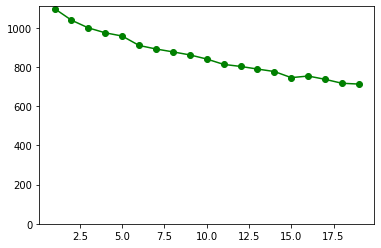

In [544]:
plt.plot(range(1,20),sse[1:20],"go-")
plt.ylim([0,1110])

In [547]:
kl = KneeLocator(range(1,20), sse[1:20], curve="convex", direction="decreasing")
kl.elbow

11

(0.0, 1200.0)

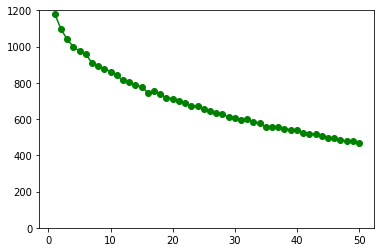

In [549]:
plt.plot(range(1,51),sse,"go-")
plt.ylim([0,1200])

In [552]:
kl = KneeLocator(range(1,51), sse[:51], curve="convex", direction="decreasing")
kl.elbow

16

Using Silhouette Coefficient

In [554]:
sc = []
new_sse = []
for k in range(2,51):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(new_features)
    score = silhouette_score(new_features, kmeans.labels_)
    sc.append(score)
    new_sse.append(kmeans.inertia_)
    print("step {}".format(k))

step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49
step 50


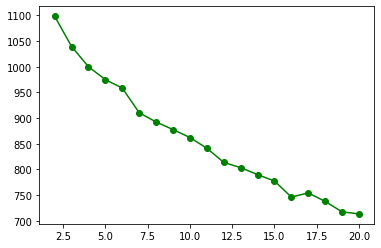

In [561]:
# for sse
plt.plot(range(2,21), new_sse[:19], "go-")

In [562]:
kl_new = KneeLocator(range(2,21), new_sse[:19], curve="convex", direction="decreasing")
kl_new.elbow

12

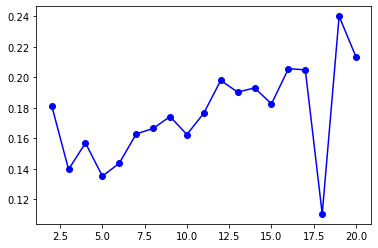

In [563]:
# for silhouette coefficient
plt.plot(range(2,21), sc[:19], "bo-")

Text(0.5, 0, 'k')

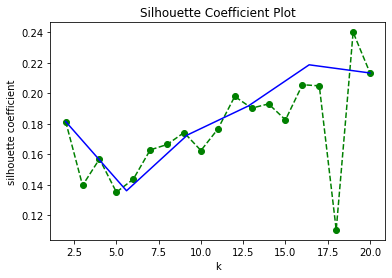

In [565]:


spl = make_interp_spline(range(2,21), sc[:19], k=3)  # type: BSpline

xs = np.linspace(2, 20, 6)
ys = spl(xs)

plt.plot(range(2,21), sc[:19], "go--")
plt.plot(xs, ys, "b-")
plt.title("Silhouette Coefficient Plot")
plt.ylabel("silhouette coefficient")
plt.xlabel("k")

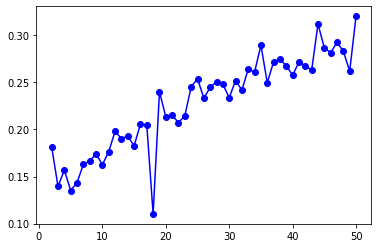

In [566]:
# for silhouette coefficient
plt.plot(range(2,51), sc, "bo-")

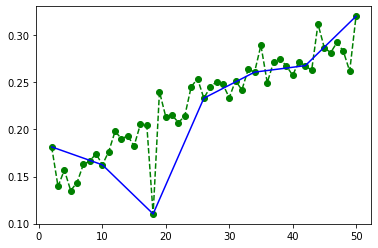

In [567]:


spl = make_interp_spline(range(2,51), sc, k=3)  # type: BSpline

xs = np.linspace(2, 50, 7)
ys = spl(xs)

plt.plot(range(2,51), sc, "go--")
plt.plot(xs, ys, "b-")

In [568]:
len(sc)

49

In [569]:
print([k for k in range(len(sc)) if sc[k]==max(sc)])

[48]


Clusters

In [519]:
kmeans = KMeans(n_clusters = 12, init="k-means++", n_init = 50, max_iter = 500, random_state = 360)
kmeans.fit(new_features)

KMeans(max_iter=500, n_clusters=12, n_init=50, random_state=360)

In [520]:
clustered = defaultdict(list)
for idx,ns in enumerate(newssources):
    c = kmeans.labels_[idx]
    clustered[c].append(ns)

In [521]:
print([len(clustered[i]) for i in range(12)])

[1643, 177, 380, 119, 36, 43, 37, 101, 100, 56, 31, 62]


In [522]:
clustered[8]

['wsbt.com',
 'latimes.com',
 'thedailybeast.com',
 'japantimes.co.jp',
 'fox10tv.com',
 'globegazette.com',
 'wtae.com',
 'thesouthern.com',
 'scmp.com',
 'wjla.com',
 'siouxcityjournal.com',
 'winonadailynews.com',
 'civilbeat.org',
 'wqad.com',
 'fox61.com',
 'wccbcharlotte.com',
 'wapt.com',
 'wlos.com',
 'post-gazette.com',
 'boston.com',
 'foxnews.com',
 'telegraph.co.uk',
 'sciencedaily.com',
 'wsvn.com',
 'albanyherald.com',
 'foxsanantonio.com',
 'abc57.com',
 'bangkokpost.com',
 'wvtm13.com',
 'kmov.com',
 'wowt.com',
 'wchstv.com',
 'ketv.com',
 'dothaneagle.com',
 '5newsonline.com',
 'wesh.com',
 'npr.org',
 'wsmv.com',
 'cnn.com',
 'wtkr.com',
 'ktbs.com',
 'pbs.org',
 'fox11online.com',
 'fox43.com',
 'thetandd.com',
 'wnep.com',
 'cbs58.com',
 'chicagotribune.com',
 'abc13.com',
 'wfsb.com',
 'nytimes.com',
 'cbs46.com',
 'smh.com.au',
 'blackhillsfox.com',
 'phillytrib.com',
 'espn.com',
 'kshb.com',
 'wlky.com',
 'wjcl.com',
 'nzherald.co.nz',
 'wpbf.com',
 'thehill.co

In [524]:
print([k for k in range(25) if "foxnews.com" in clustered[k]])

[8]


In [518]:
?KMeans

## Low Variance
What about selecting features using `skfeature.function.statistical_based.low_variance`

First let's look at the various variances of the feature columns.

In [163]:
variances = [statistics.pvariance([row[idx] for row in features]) for idx in range(len(features[0]))]

In [164]:
len(variances)

6220

In [165]:
max(variances)

0.036082942854536185

Text(0.5, 0, 'variance')

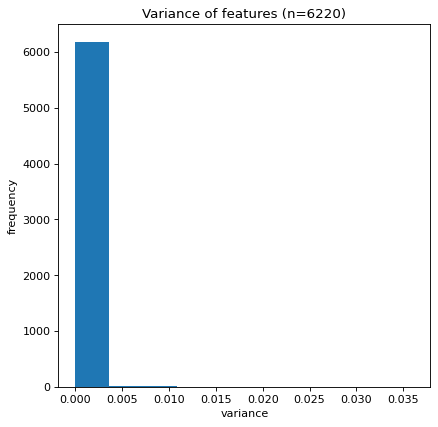

In [183]:
figure(figsize=(6, 6), dpi=80)
plt.hist([v for v in variances])
plt.title("Variance of features (n=6220)")
plt.ylabel("frequency")
plt.xlabel("variance")

Text(0.5, 0, 'variance')

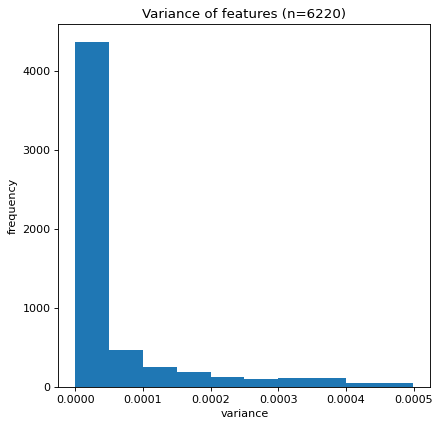

In [182]:
figure(figsize=(6, 6), dpi=80)
plt.hist([v for v in variances if v < 0.0005])
plt.title("Variance of features (n=6220)")
plt.ylabel("frequency")
plt.xlabel("variance")

In [84]:
from sklearn.feature_selection import VarianceThreshold

In [570]:
# threshold = 0.000075
selector = VarianceThreshold(threshold=0.0009)
new_features = selector.fit_transform(np.array(features))

In [571]:
len(new_features[0])

206

In [572]:
# ?VarianceThreshold

## Clustering

For starters, let's try 5 clusters

In [573]:
items = new_features.tolist()

In [574]:
kmeans5 = KMeans(init = "random",
               n_clusters = 5,
               n_init = 10,
               max_iter = 100)

In [575]:
kmeans5.fit(new_features)

KMeans(init='random', max_iter=100, n_clusters=5)

In [576]:
kmeans5.inertia_

1277.426789424867

In [538]:
kmeans5.n_iter_

11

### Choosing the appropriate number of clusters

In [539]:
# Elbow method
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 56789432
}

In [540]:
sse = []
for k in range(1,51):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(new_features)
    sse.append(kmeans.inertia_)
    print(f"have done {k} rounds, current sse is {sse}")

have done 1 rounds, current sse is [1181.5526665082493]
have done 2 rounds, current sse is [1181.5526665082493, 1098.472476007342]
have done 3 rounds, current sse is [1181.5526665082493, 1098.472476007342, 1039.4780670125913]
have done 4 rounds, current sse is [1181.5526665082493, 1098.472476007342, 1039.4780670125913, 1000.0703800378031]
have done 5 rounds, current sse is [1181.5526665082493, 1098.472476007342, 1039.4780670125913, 1000.0703800378031, 974.9401001543215]
have done 6 rounds, current sse is [1181.5526665082493, 1098.472476007342, 1039.4780670125913, 1000.0703800378031, 974.9401001543215, 958.4477950359568]
have done 7 rounds, current sse is [1181.5526665082493, 1098.472476007342, 1039.4780670125913, 1000.0703800378031, 974.9401001543215, 958.4477950359568, 910.4432901039212]
have done 8 rounds, current sse is [1181.5526665082493, 1098.472476007342, 1039.4780670125913, 1000.0703800378031, 974.9401001543215, 958.4477950359568, 910.4432901039212, 892.3635832810944]
have done

have done 28 rounds, current sse is [1181.5526665082493, 1098.472476007342, 1039.4780670125913, 1000.0703800378031, 974.9401001543215, 958.4477950359568, 910.4432901039212, 892.3635832810944, 877.6928545282547, 862.1831324893084, 841.1860183023703, 813.7804221524965, 803.4008714221554, 789.957184078137, 777.3342176410414, 746.1644820414118, 754.2898605168607, 737.5561425720664, 717.3459063562636, 713.3257270444758, 699.2864690433057, 686.2732502996422, 670.3643331312983, 673.1405394882684, 656.5107834514625, 642.3078291269134, 635.5540840525023, 626.9219869868864]
have done 29 rounds, current sse is [1181.5526665082493, 1098.472476007342, 1039.4780670125913, 1000.0703800378031, 974.9401001543215, 958.4477950359568, 910.4432901039212, 892.3635832810944, 877.6928545282547, 862.1831324893084, 841.1860183023703, 813.7804221524965, 803.4008714221554, 789.957184078137, 777.3342176410414, 746.1644820414118, 754.2898605168607, 737.5561425720664, 717.3459063562636, 713.3257270444758, 699.286469

have done 41 rounds, current sse is [1181.5526665082493, 1098.472476007342, 1039.4780670125913, 1000.0703800378031, 974.9401001543215, 958.4477950359568, 910.4432901039212, 892.3635832810944, 877.6928545282547, 862.1831324893084, 841.1860183023703, 813.7804221524965, 803.4008714221554, 789.957184078137, 777.3342176410414, 746.1644820414118, 754.2898605168607, 737.5561425720664, 717.3459063562636, 713.3257270444758, 699.2864690433057, 686.2732502996422, 670.3643331312983, 673.1405394882684, 656.5107834514625, 642.3078291269134, 635.5540840525023, 626.9219869868864, 611.0813070767288, 608.6201068302411, 597.2167743767546, 597.8054341658324, 585.851648980538, 576.2103400902283, 557.3124263231155, 558.5881053185614, 555.729025997807, 545.3083553743882, 542.0169734882461, 539.3400353263198, 525.5460627571496]
have done 42 rounds, current sse is [1181.5526665082493, 1098.472476007342, 1039.4780670125913, 1000.0703800378031, 974.9401001543215, 958.4477950359568, 910.4432901039212, 892.3635832

(0.0, 1110.0)

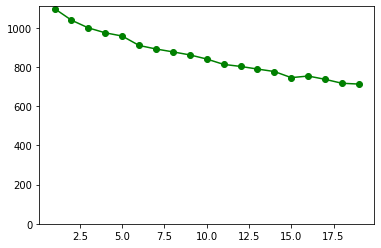

In [544]:
plt.plot(range(1,20),sse[1:20],"go-")
plt.ylim([0,1110])

In [547]:
kl = KneeLocator(range(1,20), sse[1:20], curve="convex", direction="decreasing")
kl.elbow

11

(0.0, 1200.0)

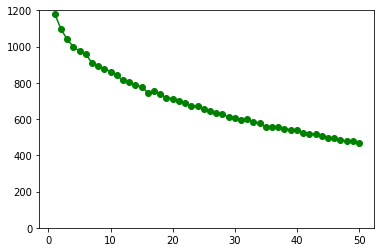

In [549]:
plt.plot(range(1,51),sse,"go-")
plt.ylim([0,1200])

In [552]:
kl = KneeLocator(range(1,51), sse[:51], curve="convex", direction="decreasing")
kl.elbow

16

Using Silhouette Coefficient

In [554]:
sc = []
new_sse = []
for k in range(2,51):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(new_features)
    score = silhouette_score(new_features, kmeans.labels_)
    sc.append(score)
    new_sse.append(kmeans.inertia_)
    print("step {}".format(k))

step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49
step 50


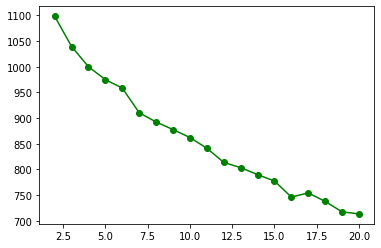

In [561]:
# for sse
plt.plot(range(2,21), new_sse[:19], "go-")

In [562]:
kl_new = KneeLocator(range(2,21), new_sse[:19], curve="convex", direction="decreasing")
kl_new.elbow

12

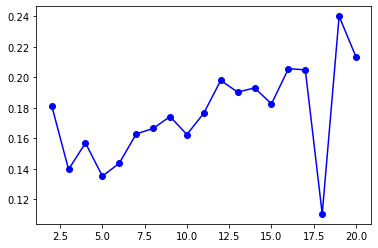

In [563]:
# for silhouette coefficient
plt.plot(range(2,21), sc[:19], "bo-")

Text(0.5, 0, 'k')

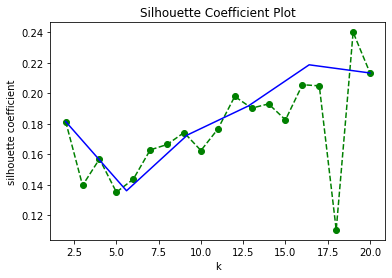

In [565]:


spl = make_interp_spline(range(2,21), sc[:19], k=3)  # type: BSpline

xs = np.linspace(2, 20, 6)
ys = spl(xs)

plt.plot(range(2,21), sc[:19], "go--")
plt.plot(xs, ys, "b-")
plt.title("Silhouette Coefficient Plot")
plt.ylabel("silhouette coefficient")
plt.xlabel("k")

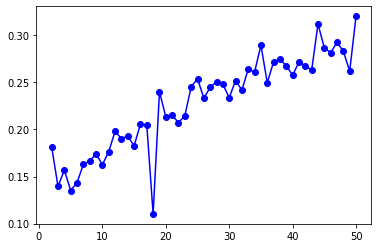

In [566]:
# for silhouette coefficient
plt.plot(range(2,51), sc, "bo-")

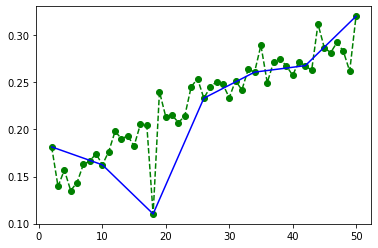

In [567]:


spl = make_interp_spline(range(2,51), sc, k=3)  # type: BSpline

xs = np.linspace(2, 50, 7)
ys = spl(xs)

plt.plot(range(2,51), sc, "go--")
plt.plot(xs, ys, "b-")

In [568]:
len(sc)

49

In [569]:
print([k for k in range(len(sc)) if sc[k]==max(sc)])

[48]


Clusters

In [519]:
kmeans = KMeans(n_clusters = 12, init="k-means++", n_init = 50, max_iter = 500, random_state = 360)
kmeans.fit(new_features)

KMeans(max_iter=500, n_clusters=12, n_init=50, random_state=360)

In [520]:
clustered = defaultdict(list)
for idx,ns in enumerate(newssources):
    c = kmeans.labels_[idx]
    clustered[c].append(ns)

In [521]:
print([len(clustered[i]) for i in range(12)])

[1643, 177, 380, 119, 36, 43, 37, 101, 100, 56, 31, 62]


In [522]:
clustered[8]

['wsbt.com',
 'latimes.com',
 'thedailybeast.com',
 'japantimes.co.jp',
 'fox10tv.com',
 'globegazette.com',
 'wtae.com',
 'thesouthern.com',
 'scmp.com',
 'wjla.com',
 'siouxcityjournal.com',
 'winonadailynews.com',
 'civilbeat.org',
 'wqad.com',
 'fox61.com',
 'wccbcharlotte.com',
 'wapt.com',
 'wlos.com',
 'post-gazette.com',
 'boston.com',
 'foxnews.com',
 'telegraph.co.uk',
 'sciencedaily.com',
 'wsvn.com',
 'albanyherald.com',
 'foxsanantonio.com',
 'abc57.com',
 'bangkokpost.com',
 'wvtm13.com',
 'kmov.com',
 'wowt.com',
 'wchstv.com',
 'ketv.com',
 'dothaneagle.com',
 '5newsonline.com',
 'wesh.com',
 'npr.org',
 'wsmv.com',
 'cnn.com',
 'wtkr.com',
 'ktbs.com',
 'pbs.org',
 'fox11online.com',
 'fox43.com',
 'thetandd.com',
 'wnep.com',
 'cbs58.com',
 'chicagotribune.com',
 'abc13.com',
 'wfsb.com',
 'nytimes.com',
 'cbs46.com',
 'smh.com.au',
 'blackhillsfox.com',
 'phillytrib.com',
 'espn.com',
 'kshb.com',
 'wlky.com',
 'wjcl.com',
 'nzherald.co.nz',
 'wpbf.com',
 'thehill.co

In [524]:
print([k for k in range(25) if "foxnews.com" in clustered[k]])

[8]


In [518]:
?KMeans